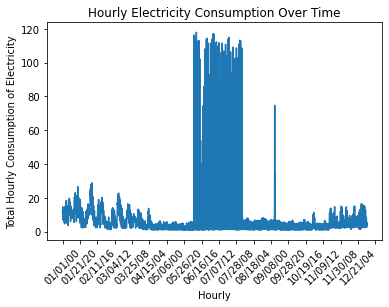

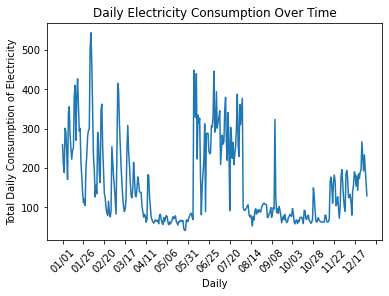

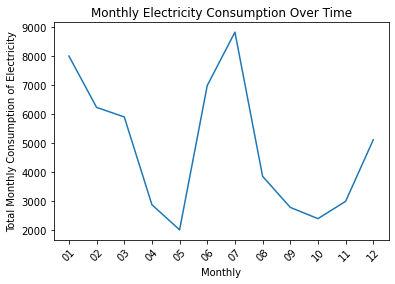

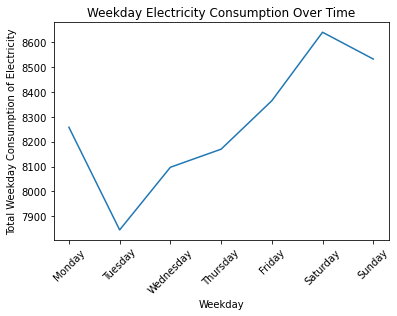

In [147]:
from dfply import *
import pandas as pd
import numpy as np

#read the main data and label it in formal timestamps
#in the original data we have 24:00:00 to represent hourly electric used from 23:00:00-24:00:00
#however, 24:00:00 is not a timestamp formally used in python
#we updata the timestamp to one hour earlier, for example 24:00:00 to 23:00:00, 01:00:00 to 00:00:00
df=pd.read_csv("./data/Assignment 2 - USA_AL_Auburn-Opelika.AP.722284_TMY3_BASE.csv")
df["Date/Time"] = df["Date/Time"].str.strip()
df["Date/Time"] = df["Date/Time"].str.replace(" 24:00:00", " 23:59:59")
df["Date/Time"] = pd.to_datetime(df["Date/Time"], format="%m/%d  %H:%M:%S")-pd.DateOffset(hours=1)+pd.DateOffset(seconds=1)
df["Date/Time"] = df["Date/Time"].dt.strftime("%m/%d %H:00:00")

#read the additional data and group it by hours
#to align with the label for the main data our grouping and labeling method is as follows
#we group 00:00-00:59 data to 00:00:00, 23:00-23:59 data to 23:00:00
df_new=pd.read_csv("./data/Assignment 2 - new.app4.csv",index_col=0)
df_new["Date/Time"]=pd.to_datetime(df_new["time"], format="%m/%d/%Y %H:%M")
df_new["Date/Time"]=df_new["Date/Time"].dt.strftime("%m/%d %H:00:00")
df_grouped=df_new >> group_by("Date/Time") >> summarize(W_min_sum=X.W_min.sum()/1000)

#we join the additional data to the main data and calculate a "total" for the total electricity used per hour
result_df=df >> left_join(df_grouped, by="Date/Time")
result_df["total"] = result_df.select_dtypes(include="number").sum(axis=1, skipna=True)


#create hourly data to plot
result_df["Hour"]=pd.to_datetime(result_df["Date/Time"], format="%m/%d %H:00:00")
result_df["Hour"]=result_df["Hour"].dt.strftime("%m/%d/%H")
result_df_hour=result_df >> group_by("Hour") >> summarize(total=X.total.sum())

#create daily data to plot
result_df["Day"]=pd.to_datetime(result_df["Date/Time"], format="%m/%d %H:00:00")
result_df["Day"]=result_df["Day"].dt.strftime("%m/%d")
result_df_day=result_df >> group_by("Day") >> summarize(total=X.total.sum())

#create monthly data to plot
result_df["Month"]=pd.to_datetime(result_df["Date/Time"], format="%m/%d %H:00:00")
result_df["Month"]=result_df["Month"].dt.strftime("%m")
result_df_month=result_df >> group_by("Month") >> summarize(total=X.total.sum())

#create weekday data to plot
result_df["Weekday"]=pd.to_datetime(result_df["Date/Time"], format="%m/%d %H:00:00")
result_df["Weekday"]=result_df["Weekday"].dt.day_name()
result_df_weekday=result_df >> group_by("Weekday") >> summarize(total=X.total.sum())
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
result_df_weekday["Weekday"] = pd.Categorical(result_df_weekday["Weekday"], categories=weekday_names, ordered=True)
result_df_weekday = result_df_weekday.sort_values("Weekday")

def plot_data(data,x_axis,y_axis,label):
    import matplotlib.pyplot as plt
    plt.plot(data[x_axis], data[y_axis])
    plt.xlabel(label)
    plt.ylabel("Total " + label + " Consumption of Electricity")
    plt.title(label+" Electricity Consumption Over Time")
    plt.xticks(rotation=45)
    if len(data[x_axis]) > 20:
        plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))
    plt.show()

plot_data(result_df_hour,"Hour","total","Hourly")
plot_data(result_df_day,"Day","total","Daily")
plot_data(result_df_month,"Month","total","Monthly")
plot_data(result_df_weekday,"Weekday","total","Weekday")